[View in Colaboratory](https://colab.research.google.com/github/debu999/keraslearn/blob/master/salt_identification.ipynb)

In [29]:
#Download Dependencies
!pip install imageio
!pip install torch
!pip install kaggle
#!pip install pywidgets

    100% |████████████████████████████████| 3.3MB 1.0MB/s 
  Running setup.py bdist_wheel for imageio ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/e0/43/31/605de9372ceaf657f152d3d5e82f42cf265d81db8bbe63cde1
Successfully built imageio
    100% |████████████████████████████████| 519.5MB 27kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59098000 @  0x7fc08a3d51c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 2.2MB/s 
    100% |████████████████████████████████| 235kB 4.8MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/44/2c/df/22a6eeb780c36c28190faef6252b739fdc47145fd87a6642d4
  Running setup.py bdist_wheel for python-slugify ... - d

In [0]:
#import dependencies
import os
import numpy as np
import pandas as pd
import platform
from pprint import pprint as pp
import imageio
import matplotlib.pyplot as plt
import torch
from torch.utils import data


In [37]:
pp([platform.architecture(), platform.platform(), platform.processor(), platform.system()])

[('64bit', ''),
 'Linux-4.14.33+-x86_64-with-Ubuntu-17.10-artful',
 'x86_64',
 'Linux']


In [66]:
#upload the kaggle credentials
from google.colab import files
files.upload()

{}

In [39]:
#is it there?
ls -lrt kaggle*

-rw-r--r-- 1 root root 62 Sep 13 02:22 kaggle.json


In [40]:
#create kaggle folder whoami is root
!rm -rfv ~/.kaggle
!mkdir -pv ~/.kaggle
!cp -v kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

removed directory '/root/.kaggle'
mkdir: created directory '/root/.kaggle'
'kaggle.json' -> '/root/.kaggle/kaggle.json'


In [41]:
#Download our Dataset
import sys
from kaggle import cli
"""If you have not joined the competition it will send 403 error.
Please join the competition."""

"""--force is to force download the file even if its already downloded."""
sys.argv = 'kaggle competitions download -c tgs-salt-identification-challenge --force'.split()

"""calling kaggle cli to get the files using credentials from ~/.kaggle/kaggle.json"""
cli.main()
# !kaggle competitions download -c tgs-salt-identification-challenge 

100%|██████████| 322k/322k [00:00<00:00, 43.0MB/s]


100%|██████████| 264k/264k [00:00<00:00, 38.9MB/s]


100%|██████████| 922k/922k [00:00<00:00, 99.2MB/s]


  6%|▌         | 9.00M/163M [00:00<00:01, 86.6MB/s]

100%|██████████| 163M/163M [00:00<00:00, 200MB/s]


 37%|███▋      | 14.0M/37.9M [00:00<00:00, 144MB/s]

100%|██████████| 37.9M/37.9M [00:00<00:00, 199MB/s]


In [42]:
!ls -lrt /root/.kaggle/
!ls -lrt

total 4
-rw------- 1 root root 62 Sep 13 02:22 kaggle.json
total 207600
drwxr-xr-x 2 root root      4096 Sep 11 17:54 sample_data
-rw-r--r-- 1 root root        62 Sep 13 02:22 kaggle.json
-rw-r--r-- 1 root root    329525 Sep 13 02:22 depths.csv
-rw-r--r-- 1 root root    270012 Sep 13 02:22 sample_submission.csv
-rw-r--r-- 1 root root    943702 Sep 13 02:22 train.csv
-rw-r--r-- 1 root root 171262199 Sep 13 02:22 test.zip
-rw-r--r-- 1 root root  39757560 Sep 13 02:22 train.zip


In [43]:
#Unzip
!unzip train.zip

Archive:  train.zip
   creating: images/
   creating: masks/
  inflating: images/8d08955cdf.png   
  inflating: images/e045664b46.png   
  inflating: images/4989c6509e.png   
  inflating: images/fff4eb4941.png   
  inflating: images/3a310860a3.png   
  inflating: images/7a696bb878.png   
  inflating: images/8d3ee9356b.png   
  inflating: images/213e0a9f7b.png   
  inflating: images/78f17697f2.png   
  inflating: images/bd20d18369.png   
  inflating: images/de08c5a3b7.png   
  inflating: images/f06ef6c8b7.png   
  inflating: images/b2d02516e1.png   
  inflating: images/5edb37f5a8.png   
  inflating: images/b1f0e104f5.png   
  inflating: images/40e8e14e60.png   
  inflating: images/6e1444d88d.png   
  inflating: images/f342603c76.png   
  inflating: images/7ba58ee1be.png   
  inflating: images/14a89a1840.png   
  inflating: images/4319885cf1.png   
  inflating: images/bb697642ae.png   
  inflating: images/d4acb30303.png   
  inflating: images/057eae4f34.png   
  inflating: images/9f0c9f3

In [0]:
#Lets create a class to hold our dataset
import os
import numpy as np

class TGSSaltDataset(data.Dataset):
  def __init__(self, root_path, file_list):
    self.root_path = root_path
    self.file_list = file_list
    
  def __len__(self):
    return len(self.file_list)
  
  def __getitem__(self, index):
    file_id = self.file_list[index]
    #image folder + path
    image_folder = os.path.join(self.root_path, "images")
    image_path = os.path.join(image_folder, ".".join([file_id, "png"]))
    
    #mask folder + path
    mask_folder = os.path.join(self.root_path, "masks")
    mask_path = os.path.join(mask_folder, ".".join([file_id, "png"]))
    
    #read the data
    image = np.array(imageio.imread(image_path), dtype=np.uint8)
    mask = np.array(imageio.imread(mask_path), dtype=np.uint8)
#     print(image_path, mask_path)
    return image, mask
  
  

In [0]:
#initialise by adding the data to the platform
train_mask = pd.read_csv("train.csv")
depth = pd.read_csv("depths.csv")
train_path = "./"
file_list = list(train_mask.id.values)
dataset = TGSSaltDataset(train_path, file_list)


In [0]:
#Function to visualize the images
def plot2x2array(image, mask):
  #plot matplotlib plots to visualize data
  f, arr = plt.subplots(1, 2)
  arr[0].imshow(image)
  arr[1].imshow(mask)
  arr[0].grid()
  arr[1].grid()
  arr[0].set_title("Image")
  arr[1].set_title("Mask")
  

  
  

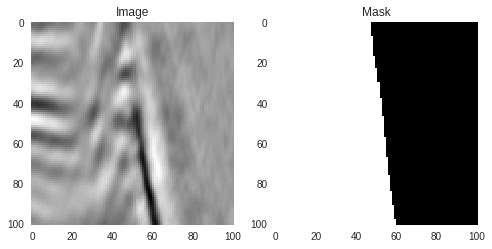

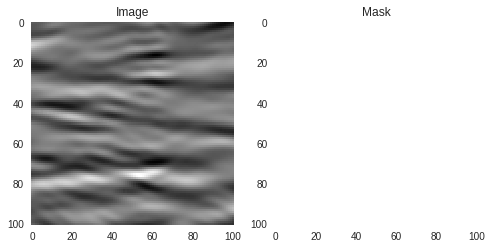

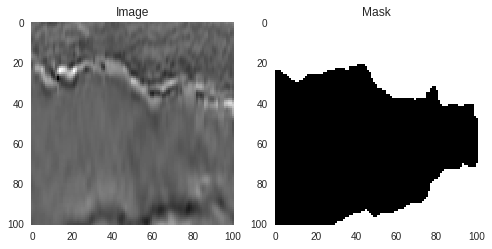

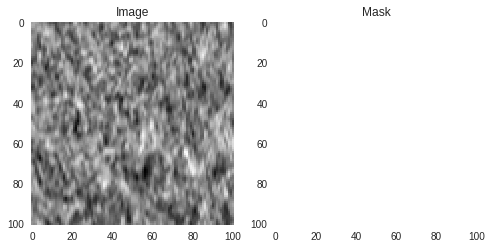

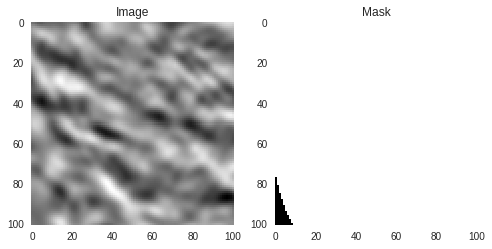

In [47]:
#print the images

for i in range(5):
  image, mask = dataset[np.random.randint(0, len(dataset))]
  plot2x2array(image, mask=mask)

Text(0.5,1,'Depth Distribution')

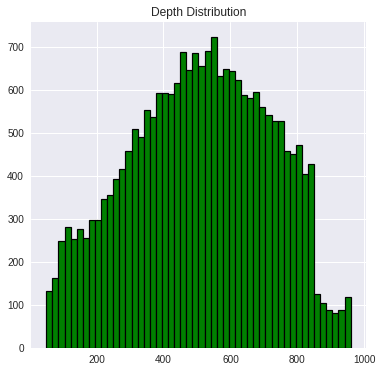

In [48]:
#plot distribution of depths
plt.figure(figsize=(6,6))
plt.hist(depth.z, bins=50, color="green", edgecolor='black', linewidth=1.2)
plt.title("Depth Distribution")

In [0]:
#Convert run length encoding to correct values
def rleToMask(rlestring, height, width):
  rows, cols = height, width
  try:
    rleNum = [int(numstr) for numstr in rlestring.split(" ")]
    rlePairs = np.array(rleNum).reshape(-1, 2)
    img = np.zeros(rows*cols, dtype= np.uint8)
    for idx, length in rlePairs:
      idx -= 1
      img[idx:idx+length]=255
    
    img = img.reshap(cols, rows).T
    print("hola")
  except Exception as err:
    img = np.zeros(rows*cols, dtype= np.uint8)
    
  return img


In [57]:
import numpy as np
a=range(15)
print(np.array(a).reshape(5,3).T, np.array(a).reshape(3,5).T)


[[ 0  3  6  9 12]
 [ 1  4  7 10 13]
 [ 2  5  8 11 14]] [[ 0  5 10]
 [ 1  6 11]
 [ 2  7 12]
 [ 3  8 13]
 [ 4  9 14]]


In [0]:
#function for how salty a image is
def saltProportion(imgarr):
  try:
    unique, counts = np.unique(imgarr, return_counts=True)
    return counts[1]/10201.
  except:
    return 0.0
  

In [64]:
train_mask.rel_mask.iloc[2]

AttributeError: ignored

In [0]:
#merge it
merged = train_mask.merge(depth, how=left)
merged.head()